In [3]:
#Data manipulation and visualisation
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Import file

In [4]:
main = pd.read_csv("sample_200k.csv")

In [5]:
main.shape

(200000, 63)

In [6]:
main.columns

Index(['borr_id', 'gender', 'birthyear', 'maritalstatus', 'numofdependence',
       'education', 'professionid', 'homestatus', 'staysinceyear',
       'EmploymentSinceYear', 'MainBusinessSinceYear', 'jobtypeid', 'jobpos',
       'monthlyfixedincome', 'monthlyvariableincome', 'spouseincome',
       'newapplicationdate', 'MaxOverDueDays', 'residencezipcode',
       'companyzipcode', 'legalzipcode', 'residence_lat', 'residence_long',
       'company_lat', 'company_long', 'legal_lat', 'legal_long', 'birthplace',
       'avg_income', 'std_income', 'avg_income_cnt', 'avg_income_nation',
       'std_income_nation', 'avg_income_nation_cnt', 'avg_income_area',
       'std_icnome_area', 'avg_income_area_cnt', 'avg_sale_house_price_5000',
       'std_sale_house_price_5000', 'sale_house_cnt_5000',
       'avg_sale_apartment_price_5000', 'std_sale_apartment_price_5000',
       'sale_apartment_cnt_5000', 'avg_rent_house_price_5000',
       'std_rent_house_price_5000', 'rent_house_cnt_5000',
       '

In [8]:
df = main.copy()

# Trim Irrelevant columns

In [9]:
# remove state demographic (non-personal data)
df = df[df.columns[:18]]

#remove ID and application date
df.drop(["borr_id","newapplicationdate"],axis = "columns", inplace=True)

In [14]:
df.head(5)

,gender,birthyear,maritalstatus,numofdependence,education,professionid,homestatus,staysinceyear,EmploymentSinceYear,MainBusinessSinceYear,jobtypeid,jobpos,monthlyfixedincome,monthlyvariableincome,spouseincome,MaxOverDueDays
0,Male,1985,SINGLE,0,BACHELOR_DEGREE,Government employees,4,2010,2006.0,NaN,Others,Staff,4000000.0,0,0.0,0
1,Male,1969,MARRIED,2,ELEMENTARY_SCHOOL,Entrepreneur,1,1992,NaN,2005.0,Entrepreneur,NaN,3000000.0,0,0.0,7
2,Female,1976,MARRIED,2,SENIOR_HIGH_SCHOOL,Entrepreneur,1,2008,NaN,2010.0,Entrepreneur,NaN,3000000.0,0,0.0,17
3,Male,1985,MARRIED,1,ELEMENTARY_SCHOOL,Entrepreneur,1,2002,NaN,2005.0,Entrepreneur,NaN,5000000.0,0,0.0,10
4,Female,1979,MARRIED,1,ELEMENTARY_SCHOOL,Entrepreneur,1,2007,NaN,2007.0,Entrepreneur,NaN,3800000.0,0,0.0,10


# data cleaning

## missing data 

In [15]:
df.isna().sum()

gender                        0
birthyear                     0
maritalstatus                 8
numofdependence               0
education                     0
professionid                  0
homestatus                    0
staysinceyear                 0
EmploymentSinceYear       91140
MainBusinessSinceYear    105317
jobtypeid                   137
jobpos                    85155
monthlyfixedincome            0
monthlyvariableincome         0
spouseincome                  8
MaxOverDueDays                0
dtype: int64

### Employment year missing data 

In [16]:
# Employment and Business ownership is mutually exclusive 
sum(df["EmploymentSinceYear"].notna() == df["MainBusinessSinceYear"].isna())

196397

In [17]:
employment_frame = df[["EmploymentSinceYear", "MainBusinessSinceYear"]]
employment_frame.fillna(method="backfill",axis="columns",inplace=True)
df["employment_year"] = employment_frame["EmploymentSinceYear"]
df.drop(["EmploymentSinceYear", "MainBusinessSinceYear"],axis = "columns", inplace=True)

C:\Users\FAN_HUI\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### employment type missing data

We will focus on job position as it has 1) more distinct levels and is 2) ordinal

In [18]:
#isolate columns for job
job_frame = df[["jobtypeid", "jobpos"]]

In [19]:
#what exact comprises "others" in job pos. Mostly entrepreneurs @ 82%
job_frame[job_frame["jobpos"]=="Others"]["jobtypeid"].value_counts(normalize=True)

Entrepreneur                 0.816826
Others                       0.160971
Security                     0.005609
Doctor                       0.003238
Military / Army-Police       0.002602
Collector                    0.002082
Midwife                      0.001735
Education                    0.001677
Government                   0.001503
Theologian and Pastor        0.001388
Marketing                    0.000983
Farmer                       0.000347
Engineering                  0.000231
General Administration       0.000173
Fisherman                    0.000116
Retired                      0.000116
Student / College Student    0.000116
Notary Public                0.000116
Artist & Entertainment       0.000058
Journalist                   0.000058
Housewife                    0.000058
Name: jobtypeid, dtype: float64

In [20]:
#find out the contribution of missing jobpos. bulk are entrepreneur, others and education (assuming self employed tutors)
missing_job_frame= job_frame[job_frame["jobpos"].isna()]
missing_job_frame["jobtypeid"].value_counts() / len(df)

Entrepreneur                 0.394510
Others                       0.015225
Education                    0.013210
Doctor                       0.000565
Housewife                    0.000435
Theologian and Pastor        0.000410
Military / Army-Police       0.000350
Student / College Student    0.000235
Security                     0.000135
Journalist                   0.000025
Government / Legislative     0.000015
Collector                    0.000015
Artist & Entertainment       0.000010
Name: jobtypeid, dtype: float64

In [21]:
job_frame.fillna(method="ffill", axis = "columns", inplace = True)

# convert entrepreneur, others and education to self-employed
def clean_pos(value):
    if value == "Entrepreneur":
        return "self-employed"
    elif value == "Others":
        return "self-employed"
    elif value == "Education":
        return "self-employed"
    else:
        return value
    
job_frame["jobpos"] = job_frame["jobpos"].apply(clean_pos)
job_frame["jobpos"].value_counts()

<ipython-input-21-730eeb3c6619>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job_frame["jobpos"] = job_frame["jobpos"].apply(clean_pos)


self-employed                101886
Staff                         93387
Manager                        3375
Director                        660
Supervisor                      126
Doctor                          113
Housewife                        87
Theologian and Pastor            82
Military / Army-Police           70
Student / College Student        47
Security                         27
Journalist                        5
Government / Legislative          3
Collector                         3
Artist & Entertainment            2
Name: jobpos, dtype: int64

In [22]:
# insert filled position into main df
df["jobpos"] = job_frame["jobpos"]

In [23]:
#filter out job without proper position and drop job type column
relevant_pos = ["self-employed","Staff", "Manager", "Director", "Supervisor"]
df = df[df["jobpos"].isin(relevant_pos)]
df.drop(["jobtypeid","professionid"],axis = "columns", inplace=True)

C:\Users\FAN_HUI\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### remaining missing data

In [24]:
#assume no spouse income if there is none
df["spouseincome"].fillna(0,inplace=True)
df.isna().sum()

C:\Users\FAN_HUI\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


gender                    0
birthyear                 0
maritalstatus             8
numofdependence           0
education                 0
homestatus                0
staysinceyear             0
jobpos                    0
monthlyfixedincome        0
monthlyvariableincome     0
spouseincome              0
MaxOverDueDays            0
employment_year          28
dtype: int64

In [25]:
# drop unemployed people and with no martial status (limitation 1. can only take in employed individuals)
df = df[df["employment_year"].notna()]
df = df[df["maritalstatus"].notna()]

In [26]:
# no idea what is homestatus and does not look like numbers of room in home
df.drop("homestatus",axis = "columns", inplace=True)

In [27]:
#drop null for gender
df = df[df["gender"] != "Null"]

# Feature engineering 

In [28]:
# age
df["age"] = 2022 - df["birthyear"]
df.drop("birthyear",axis = "columns", inplace=True)

In [29]:
#household income
df["household_income"] = df["monthlyfixedincome"] + df["monthlyvariableincome"] + df["spouseincome"]
df.drop(["monthlyfixedincome","monthlyvariableincome","spouseincome"],axis = "columns", inplace=True)

In [30]:
# work experience
df["work_experience"] = 2022 - df["employment_year"]
df.drop("employment_year",axis = "columns", inplace=True)

In [31]:
# year of home ownership
df["years_home_owned"] = 2022 - df["staysinceyear"]
df.drop("staysinceyear",axis = "columns", inplace=True)

In [32]:
#convert education to ordinal level

def clean_edu(value):
    if value == "OTHERS" or value == "NOT_ATTENDING_SCHOOL" or value == "ELEMENTARY_SCHOOL":
        return 1 
    elif value == "JUNIOR_HIGH_SCHOOL" or value == "SENIOR_HIGH_SCHOOL":
        return 2
    elif value == "BACHELOR_DEGREE" or value == "TECHNICAL_COLLEGE":
        return 3
    else:
        return 4
    
df['education'] = df['education'].apply(clean_edu)

In [33]:
#default or not
def defaulted(value):
    if value > 90:
        return 1 
    else:
        return 0
    
df["status"] = df["MaxOverDueDays"].apply(defaulted)
df.drop("MaxOverDueDays",axis = "columns", inplace=True)

In [34]:
#study the portion of default rate among job position
job_frame = df[['jobpos',"status"]]

# def default_counting(value):
#     if value == "servicing":
#         return 0
#     else: 
#         return 1
    
# job_frame["status"] = job_frame["status"].apply(default_counting)

In [36]:
job_frame

,jobpos,status
0,Staff,0
1,self-employed,0
2,self-employed,0
3,self-employed,0
4,self-employed,0
...,...,...
199995,Staff,0
199996,Staff,0
199997,self-employed,1
199998,Staff,0


In [37]:
job_frame = job_frame.groupby("jobpos").agg({"status": ["count", "sum"]})
job_frame["portion"] = job_frame["status"]["sum"] / job_frame["status"]["count"]
job_frame

#the distribution seems to be equal with the exception of supervisors. Therefore, this variable must be treated 
#as norminal variable (one-hot-encoding needed)

status          portion
                count    sum          
jobpos                                
Director          660    105  0.159091
Manager          3374    408  0.120925
Staff           93383  12298  0.131694
Supervisor        126      2  0.015873
self-employed  101853  18224  0.178925

# Feature Selection

## Numerical Variables

In [39]:
#numericals variables
df_numerics = df[['numofdependence', 'education', 'jobpos',
       'age', 'household_income', 'work_experience', 'years_home_owned',
       ]]

In [1]:
#strongest coorelations at age and dependence of only 39%. All numerical features shall be retained
corr = df_numerics.corr()
corr.style.background_gradient(cmap='coolwarm')

NameError: name 'df_numerics' is not defined

## categorical variables

no single level dominated all default cases. Very little chance of model using the level as key predictor

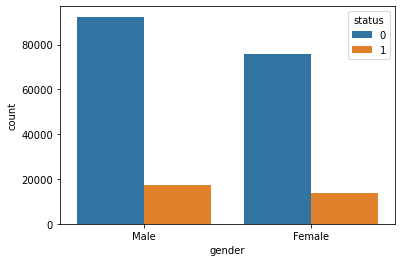

In [378]:
ax = sns.countplot(x="gender", hue="status", data=df)

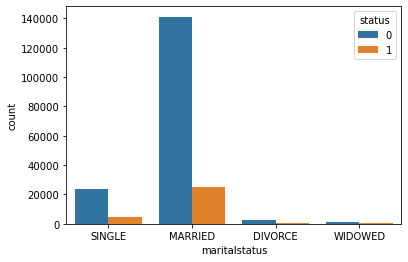

In [379]:
ax = sns.countplot(x="maritalstatus", hue="status", data=df)

In [380]:
# df.to_csv("cleaned_borrower_profile.csv", index=False)

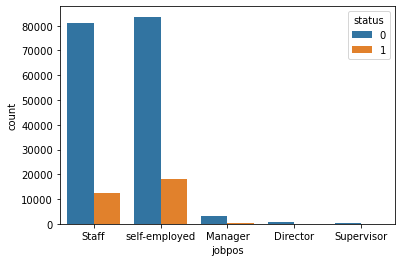

In [41]:
ax = sns.countplot(x="jobpos", hue="status", data=df)